In [2]:
STOCK_SIZE = 100

In [3]:
def read_instance(path):
    with open(path, 'r') as f:
        orders = [int(x) for x in f.readline().split()]
        return orders

# Cplex

In [8]:
from docplex.mp.model import Model

In [9]:
orders = read_instance('test_instances/test_instance_11.csp')
initial_value, initial_stocks_used = calc_solution_value(orders)
print(initial_value, initial_stocks_used)

775902 317


In [10]:
model = Model(name='CSP')

In [11]:
num_stocks = len(orders)
num_orders = len(orders)

order_list = model.integer_var_list(num_orders, lb=orders, ub=orders, name='orders')

In [12]:
order_placement = model.binary_var_matrix(num_stocks, num_orders, name='order_placement')
stock_used = model.binary_var_list(num_stocks, name='stock_used')

In [13]:
for i in range(num_stocks):
    model.add_constraint(sum(order_placement[i,j] * order_list[j] for j in range(num_orders)) <= STOCK_SIZE * stock_used[i])
    
for j in range(num_orders):
    model.add_constraint(sum(order_placement[i,j] for i in range(num_stocks)) == 1)
    
model.minimize(sum(stock_used))

In [14]:
solution = model.solve()

In [16]:
print(solution.get_objective_value())

299.0


# Simulated annealing

In [4]:
import math
from matplotlib import pyplot as plt
import random
from copy import deepcopy

In [5]:
def initialize(orders: list[int], shuffle: bool = False) -> list[int]:
    solution = deepcopy(orders)
    if shuffle:
        random.shuffle(solution)
    return solution

In [6]:
def calc_solution_value(orders: list[int]) -> tuple[int, int]:
    
    leftovers = []
    num_stocks = 0
    current_stock_size = STOCK_SIZE
    
    for order in orders:
        if order <= current_stock_size:
            current_stock_size -= order
        else:
            leftover = current_stock_size
            leftovers.append(leftover)
            num_stocks += 1
            current_stock_size = STOCK_SIZE - order
    
    if current_stock_size != STOCK_SIZE:
        leftovers.append(current_stock_size)
        
    leftovers.sort(reverse = True)
        
    result = 0    
    for i, leftover in enumerate(leftovers):
        if leftover == 0:
            break
        result += (i+1) * leftover
        
    return result, num_stocks

In [7]:
def swap(orders: list[int]): 
    idx1 = random.randrange(len(orders))
    idx2 = random.randrange(len(orders))
    while orders[idx1] == orders[idx2]:
        idx2 = random.randrange(len(orders))
        
    tmp = orders[idx1]
    orders[idx1] = orders[idx2]
    orders[idx2] = tmp
    
def insert(orders: list[int]):
    pos1 = random.randrange(len(orders))
    pos2 = random.randrange(len(orders))
    
    while pos2 == pos1:
        pos2 = random.randrange(len(orders))
        
    element = orders.pop(pos1)
    orders.insert(pos2, element)
    
def inverse(orders: list[int]):
    pos1 = random.randrange(len(orders))
    pos2 = random.randrange(len(orders))
        
    while pos2 == pos1:
        pos2 = random.randrange(len(orders))
                
    if pos1 > pos2:
        pos1,pos2 = pos2,pos1
        
    orders[pos1:pos2 + 1] = orders[pos1:pos2 + 1][::-1]

In [8]:
def calc_temperature_1(current_temp: float, alpha: float) -> float:
    return current_temp / (1 + alpha * current_temp)

def calc_temperature_2(current_temp: float, alpha: float) -> float:
    return current_temp * alpha

def calc_alpha(initial_temp: float, min_temp: float) -> float:
    return (initial_temp - min_temp) / (num_iters * initial_temp * min_temp)

In [9]:
from typing import Callable

In [10]:
def simulated_annealing(orders: list[int],
                        initial_temp: float = 100,
                        min_temp: float = 10,
                        alpha: float = 0.9,
                        max_iters: int = 10000,
                        make_small_change: Callable[[list[int]], None] = swap,
                        calc_temperature: Callable[[float, float], float] = calc_temperature_1,
                        plot: bool = False,
                        max_accepted_solutions: int = 3
                        ) -> tuple[list[int], int, int]:
    
    num_orders = len(orders)
    solution = initialize(orders)
    temperature = initial_temp
    
    value, stocks_used = calc_solution_value(solution)
    best_solution = deepcopy(solution)
    best_value = value
    best_stocks_used = stocks_used

    PLT_VALUES = []
    PLT_STOCKS_USED = []
    ITERS = 0
    
    while temperature > min_temp and ITERS < max_iters:
        accepted_solutions = 0
        new_solution = deepcopy(solution)
        make_small_change(new_solution)
        new_value, new_stocks_used = calc_solution_value(new_solution)
        
        diff = new_value - value
        if diff <= 0:
            solution = deepcopy(new_solution)
            value = new_value
            stocks_used = new_stocks_used
            
            if new_value < best_value:
                best_value = new_value
                best_solution = deepcopy(new_solution)
                best_stocks_used = new_stocks_used
                
            accepted_solutions += 1    
            
        elif random.random() < (math.e)**((-diff) / temperature):
                value = new_value
                solution = deepcopy(new_solution)
                stocks_used = new_stocks_used
                accepted_solutions += 1
        
        if diff > 0 or accepted_solutions >= max_accepted_solutions:
            temperature = calc_temperature(temperature, alpha)
        
        PLT_VALUES.append(value)
        PLT_STOCKS_USED.append(stocks_used)
        ITERS += 1
            
    if plot:      
        plt.figure(figsize=(10, 3))
        plt.subplot(1, 2, 1)
        plt.plot(range(ITERS), PLT_VALUES, label='Value')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(range(ITERS), PLT_STOCKS_USED, label='Stocks used')
        plt.legend()
        plt.show()
    
    return best_solution, best_value, best_stocks_used

In [10]:
orders = [20, 30, 50, 10, 5, 5, 80, 35, 25, 40, 8, 12, 33, 27, 20, 90, 10, 90, 2, 3, 4, 1]
random.shuffle(orders)

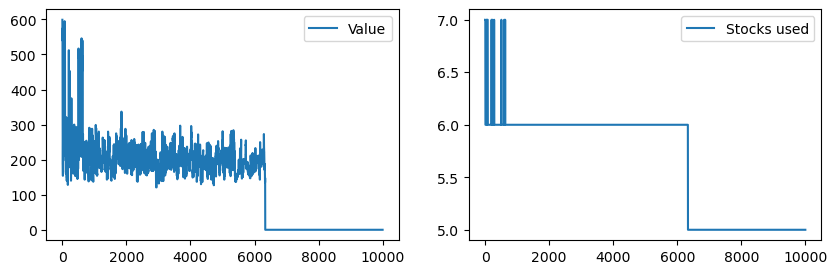

[50, 35, 2, 1, 12, 80, 20, 90, 10, 33, 40, 27, 3, 5, 4, 8, 30, 5, 20, 25, 90, 10] 0 5


In [31]:
initial_temp = 100
min_temp = 10
num_iters = 10000 # todo
a = calc_alpha(initial_temp, min_temp)
solution, value, stocks_used = simulated_annealing(orders, alpha=a, plot=True)
print(solution, value, stocks_used)

In [65]:
orders = read_instance('test_instances/test_instance_20.csp')
initial_value, initial_stocks_used = calc_solution_value(orders)
print(initial_value, initial_stocks_used)

4478851 751


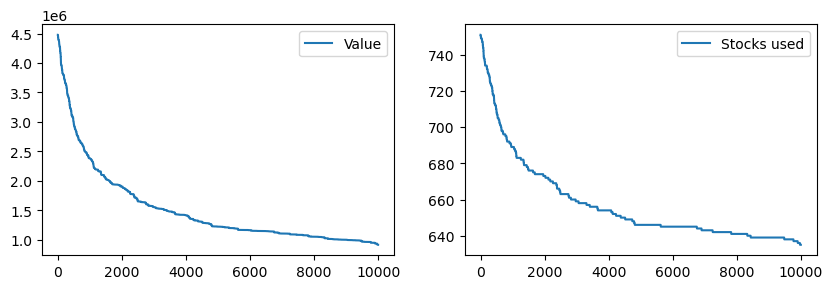

917027 635


In [62]:
#Staro

solution, value, stocks_used = simulated_annealing(orders, alpha=a, plot=True)
print(value, stocks_used)

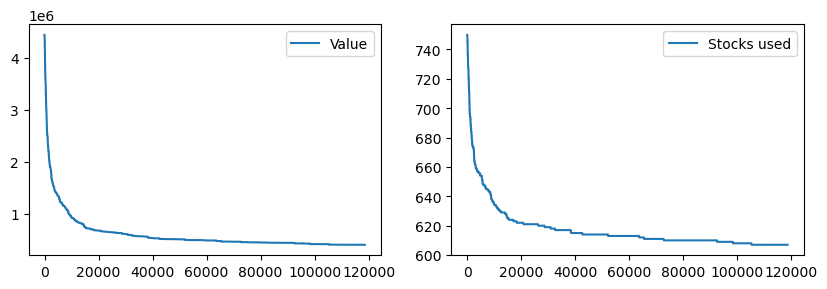

407144 607


In [68]:
solution, value, stocks_used = simulated_annealing(orders, alpha=a, plot=True, max_iters=1000000, min_temp=1)
print(value, stocks_used)

In [23]:
orders = read_instance('test_instances/test_instance_6.csp')
initial_value, initial_stocks_used = calc_solution_value(orders)
print(initial_value, initial_stocks_used)

137384 118


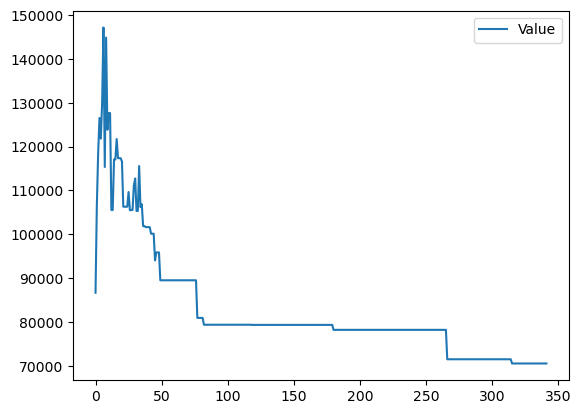

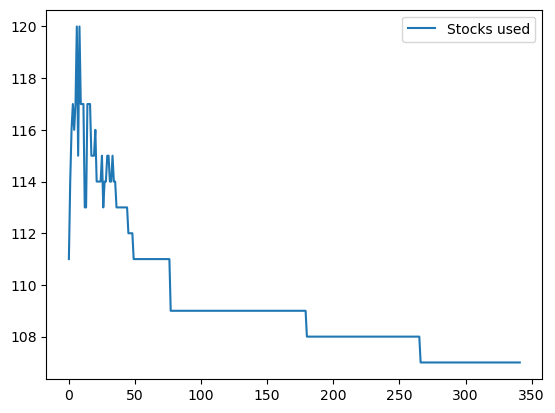

70518 107


In [24]:
solution, value, stocks_used = simulated_annealing(orders, T=40000, min_temperature=1e-3, a=0.95)
print(value, stocks_used)

### Grid search

In [43]:
import itertools

initial_temps = [50, 100, 150]
min_temps = [5, 10, 15]
max_iters = [5000, 10000, 20000]
temp_functions = [calc_temperature_1, calc_temperature_2]
max_accepted = [1, 2, 3, 4]

all_combinations = itertools.product(initial_temps, min_temps, max_iters, temp_functions, max_accepted)

In [49]:
orders = read_instance('test_instances/test_instance_20.csp')
initial_value, initial_stocks_used = calc_solution_value(orders)
print(initial_value, initial_stocks_used)

4478851 751


In [46]:
results = {}

num_combinations = len(initial_temps) * len(min_temps) * len(max_iters) * len(temp_functions) * len(max_accepted)
idx = 1

for combination in all_combinations:
    print(f'{idx}/{num_combinations}         ', end='\r')
    idx += 1
    initial_temp, min_temp, max_iters, calc_temp, max_accepted = combination
    alpha = calc_alpha(initial_temp, min_temp)
    
    solution, value, stocks_used = simulated_annealing(orders=orders,
                                                       initial_temp=initial_temp,
                                                       min_temp=min_temp,
                                                       alpha=alpha,
                                                       max_iters=max_iters,
                                                       calc_temperature=calc_temp,
                                                       max_accepted_solutions=max_accepted)
    results[combination] = (solution, value, stocks_used)

In [47]:
sorted_results = sorted(results.items(), key=lambda x: x[1][1])
for combination, (solution, value, stocks_used) in sorted_results[:10]:
    print(f"Combination: {combination}, Value: {value}, Stocks Used: {stocks_used}")

Combination: (150, 10, 20000, <function calc_temperature_1 at 0x7f0b2f008940>, 2), Value: 786169, Stocks Used: 627
Combination: (100, 15, 20000, <function calc_temperature_1 at 0x7f0b2f008940>, 2), Value: 794130, Stocks Used: 628
Combination: (100, 5, 20000, <function calc_temperature_1 at 0x7f0b2f008940>, 2), Value: 808134, Stocks Used: 628
Combination: (150, 15, 20000, <function calc_temperature_1 at 0x7f0b2f008940>, 2), Value: 820086, Stocks Used: 629
Combination: (50, 5, 20000, <function calc_temperature_1 at 0x7f0b2f008940>, 4), Value: 823690, Stocks Used: 630
Combination: (150, 15, 20000, <function calc_temperature_1 at 0x7f0b2f008940>, 4), Value: 826539, Stocks Used: 631
Combination: (150, 15, 20000, <function calc_temperature_1 at 0x7f0b2f008940>, 3), Value: 830536, Stocks Used: 630
Combination: (100, 10, 20000, <function calc_temperature_1 at 0x7f0b2f008940>, 2), Value: 831471, Stocks Used: 630
Combination: (100, 10, 10000, <function calc_temperature_1 at 0x7f0b2f008940>, 2), 

In [52]:
initial_temps = [50, 100, 150, 300]
min_temps = [5, 10, 15]
max_iters = [20000, 50000, 100000]
max_accepted = [2, 3, 4, 5]

all_combinations = itertools.product(initial_temps, min_temps, max_iters, max_accepted)

In [53]:
results = {}

num_combinations = len(initial_temps) * len(min_temps) * len(max_iters) * len(max_accepted)
idx = 1

for combination in all_combinations:
    print(f'{idx}/{num_combinations}         ', end='\r')
    idx += 1
    initial_temp, min_temp, max_iters, max_accepted = combination
    alpha = calc_alpha(initial_temp, min_temp)
    
    solution, value, stocks_used = simulated_annealing(orders=orders,
                                                       initial_temp=initial_temp,
                                                       min_temp=min_temp,
                                                       alpha=alpha,
                                                       max_iters=max_iters,
                                                       calc_temperature=calc_temperature_1,
                                                       max_accepted_solutions=max_accepted)
    results[combination] = (solution, value, stocks_used)

In [59]:
sorted_results = sorted(results.items(), key=lambda x: x[1][1])
for combination, (solution, value, stocks_used) in sorted_results[:20]:
    print(f"Combination: {combination}, Value: {value}, Stocks Used: {stocks_used}")

Combination: (100, 15, 20000, 5), Value: 757766, Stocks Used: 627
Combination: (300, 10, 100000, 4), Value: 764008, Stocks Used: 626
Combination: (100, 5, 50000, 4), Value: 765926, Stocks Used: 626
Combination: (50, 10, 50000, 4), Value: 770923, Stocks Used: 625
Combination: (150, 15, 100000, 2), Value: 780601, Stocks Used: 627
Combination: (50, 15, 100000, 2), Value: 783453, Stocks Used: 627
Combination: (300, 5, 20000, 4), Value: 783823, Stocks Used: 626
Combination: (300, 5, 100000, 2), Value: 784914, Stocks Used: 627
Combination: (150, 15, 50000, 2), Value: 786226, Stocks Used: 628
Combination: (50, 5, 100000, 5), Value: 790864, Stocks Used: 627
Combination: (300, 5, 50000, 2), Value: 790872, Stocks Used: 627
Combination: (100, 15, 100000, 4), Value: 792112, Stocks Used: 628
Combination: (100, 5, 100000, 2), Value: 792373, Stocks Used: 629
Combination: (50, 15, 50000, 5), Value: 796108, Stocks Used: 628
Combination: (300, 15, 50000, 2), Value: 800251, Stocks Used: 628
Combination: 

In [90]:
initial_temps = [random.randrange(50, 150) for _ in range(2)]
min_temps = [random.randrange(1, 15) for _ in range(2)]
max_iters = [random.randrange(1000000, 10000000) for _ in range(2)]
max_accepted = [random.randrange(1, 6) for _ in range(2)]

all_combinations = itertools.product(initial_temps, min_temps, max_iters, max_accepted)

In [91]:
results = {}
num_combinations = len(initial_temps) * len(min_temps) * len(max_iters) * len(max_accepted)
idx = 1

for combination in all_combinations:
    print(f'{idx}/{num_combinations}  ', end='\r')
    idx += 1
    initial_temp, min_temp, max_iters, max_accepted = combination
    alpha = calc_alpha(initial_temp, min_temp)
    
    solution, value, stocks_used = simulated_annealing(orders=orders,
                                                       initial_temp=initial_temp,
                                                       min_temp=min_temp,
                                                       alpha=alpha,
                                                       max_iters=max_iters,
                                                       calc_temperature=calc_temperature_1,
                                                       max_accepted_solutions=max_accepted)
    results[combination] = (solution, value, stocks_used)

In [92]:
sorted_results = sorted(results.items(), key=lambda x: x[1][1])
for combination, (solution, value, stocks_used) in sorted_results[:20]:
    print(f"Combination: {combination}, Value: {value}, Stocks Used: {stocks_used}")

Combination: (81, 11, 9346801, 4), Value: 795702, Stocks Used: 628
Combination: (138, 11, 9346801, 4), Value: 824889, Stocks Used: 629
Combination: (138, 4, 5967418, 4), Value: 825911, Stocks Used: 628
Combination: (81, 4, 5967418, 4), Value: 829744, Stocks Used: 631
Combination: (81, 4, 9346801, 1), Value: 847331, Stocks Used: 630
Combination: (81, 11, 9346801, 1), Value: 848612, Stocks Used: 630
Combination: (138, 11, 5967418, 4), Value: 850587, Stocks Used: 631
Combination: (138, 4, 9346801, 4), Value: 851102, Stocks Used: 631
Combination: (81, 11, 5967418, 4), Value: 858320, Stocks Used: 630
Combination: (81, 4, 9346801, 4), Value: 866810, Stocks Used: 632
Combination: (138, 4, 9346801, 1), Value: 873428, Stocks Used: 632
Combination: (138, 4, 5967418, 1), Value: 885159, Stocks Used: 632
Combination: (81, 11, 5967418, 1), Value: 889407, Stocks Used: 632
Combination: (81, 4, 5967418, 1), Value: 901591, Stocks Used: 632
Combination: (138, 11, 9346801, 1), Value: 908421, Stocks Used: 

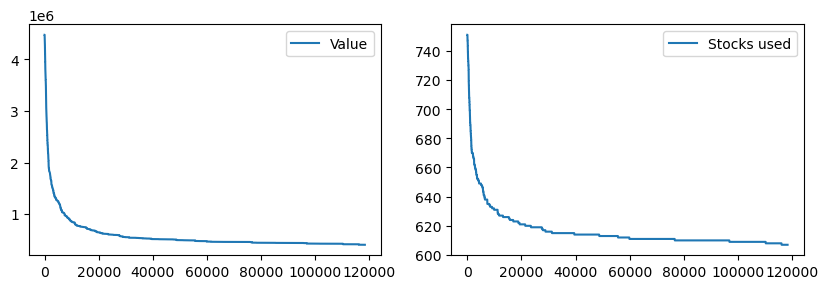

403793 607


In [93]:
solution, value, stocks_used = simulated_annealing(orders, alpha=a, plot=True, max_iters=1000000, min_temp=1)
print(value, stocks_used)

# Genetic algorithm

In [11]:
POPULATION_SIZE = 50
NUM_ITERS = 200
ELITISM_SIZE = 6
MUTATION_PROB = 0.02
CROSSOVER_PROB = 0.9
TOURNAMENT_SIZE = 6
SELECTION_PRESSURE = 1.5     # [1.0, 2.0]
MC_OPTION = 'FIXED'

class Individual:
    def __init__(self, orders):
        code = deepcopy(orders)
        random.shuffle(code)
        self.code = code
        self.fitness, self.num_stocks = calc_solution_value(self.code)

In [12]:
def ga(orders:    list[int],
       selection: Callable[[list[Individual], Individual], Individual],
       crossover: Callable[[Individual, Individual, Individual, Individual], None],
       mutation:  Callable[[Individual], None],
       plot: bool,
       POPULATION_SIZE: int,
       MC_OPTION: str,
       CROSSOVER_PROB: float,
       MUTATION_PROB: float,
       NUM_ITERS: int,
       ELITISM_SIZE: int
      ):
    
    population = [Individual(orders) for _ in range(POPULATION_SIZE)]
    new_population = deepcopy(population)
    
    PLT_VALUES = []
    PLT_STOCKS_USED = []
    
    for it in range(NUM_ITERS):
        population.sort(key=lambda x: x.fitness)
        new_population[:ELITISM_SIZE] = deepcopy(population[:ELITISM_SIZE])
        
        PLT_VALUES.append(population[0].fitness)
        PLT_STOCKS_USED.append(population[0].num_stocks)
        
        if MC_OPTION == 'DHM/ILC':
            MUTATION_PROB = 1 - (it / (NUM_ITERS - 1))
            MUTATION_PROB = mutation_lb + (mutation_ub - mutation_lb) * MUTATION_PROB

            CROSSOVER_PROB = it / (NUM_ITERS - 1)
            CROSSOVER_PROB = crossover_lb + (crossover_ub - crossover_lb) * CROSSOVER_PROB
            
        elif MC_OPTION == 'ILM/DHC':
            MUTATION_PROB = it / (NUM_ITERS - 1)
            MUTATION_PROB = mutation_lb + (mutation_ub - mutation_lb) * MUTATION_PROB
            
            CROSSOVER_PROB = 1 - (it / (NUM_ITERS - 1))
            CROSSOVER_PROB = crossover_lb + (crossover_ub - crossover_lb) * CROSSOVER_PROB
            
        for i in range(ELITISM_SIZE, POPULATION_SIZE, 2):            
            parent1 = selection(population, None)
            parent2 = selection(population, parent1)
                
            if random.random() < CROSSOVER_PROB:
                crossover(parent1, parent2, new_population[i], new_population[i+1])
            else:
                new_population[i] = deepcopy(parent1)
                new_population[i+1] = deepcopy(parent2)
            
            if random.random() < MUTATION_PROB:
                mutation(new_population[i])
            
            if random.random() < MUTATION_PROB:
                mutation(new_population[i+1]) 
                                       
            new_population[i].fitness, new_population[i].num_stocks = calc_solution_value(new_population[i].code)
            new_population[i+1].fitness, new_population[i+1].num_stocks = calc_solution_value(new_population[i+1].code)
        
        population = deepcopy(new_population)
    
    if plot:
        plt.figure(figsize=(10, 3))
        plt.subplot(1, 2, 1)
        plt.plot(range(NUM_ITERS), PLT_VALUES, label='Value')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(range(NUM_ITERS), PLT_STOCKS_USED, label='Stocks used')
        plt.legend()
        plt.show()
    
    best_individual = min(population, key=lambda x: x.fitness)
    return best_individual.code, best_individual.fitness, best_individual.num_stocks

### Selection

In [13]:
import numpy as np

In [14]:
def tournament_selection(population, forbidden):
    allowed = list(set(population).difference({forbidden}))
    chosen = random.sample(allowed, TOURNAMENT_SIZE)
    return min(chosen, key=lambda x: x.fitness)

In [15]:
def roulette_selection(population, forbidden):    
    allowed = list(set(population).difference({forbidden}))
    allowed.sort(key=lambda x: x.fitness)
    fitness_sum = sum([a.fitness for a in allowed])
    
    probs = [a.fitness / fitness_sum for a in allowed]
    probs.reverse()
    
    return np.random.choice(allowed, p=probs)

In [16]:
def rank_selection(population, forbidden):    
    allowed = list(set(population).difference({forbidden}))
    allowed.sort(key=lambda x: x.fitness)
    n = len(allowed)
    probs = [0 for i in range(n)]
    
    for i, individual in enumerate(allowed):
        probs[i] = (1 / n) * ( (SELECTION_PRESSURE - (2 * SELECTION_PRESSURE - 2) * ( i / (n - 1))) )
                        
    return np.random.choice(allowed, p=probs)    

### Crossover

In [17]:
def partially_mapped_crossover(parent1, parent2, child1, child2):
    n = len(parent1.code)
    pos1 = random.randrange(1, int(round(n/2)))
    pos2 = pos1 + random.randrange(int(round(n/3)), int(round(n/2)))
    
    temp_array1 = [(0,0) for _ in range(len(parent1.code))]
    temp_array2 = [(0,0) for _ in range(len(parent1.code))]
    
    ind_array1 = []
    ind_array2 = []
    
    count_dict1 = {}
    count_dict2 = {}

    for num in parent1.code:
        count_dict1[num] = count_dict1.get(num, 0) + 1
        ind_array1.append(count_dict1[num])
              
    for num in parent2.code:
        count_dict2[num] = count_dict2.get(num, 0) + 1
        ind_array2.append(count_dict2[num])
      
    temp_array1[pos1:pos2] = [(parent2.code[i],ind_array2[i]) for i in range(pos1, pos2)]
    temp_array2[pos1:pos2] = [(parent1.code[i],ind_array1[i]) for i in range(pos1, pos2)]

    
    #todo
    ind = 0
    for i in range(len(parent1.code)):
        if i < pos1 or i >= pos2:
            while True:
                if (parent1.code[ind], ind_array1[ind]) not in temp_array1:
                    temp_array1[i] = (parent1.code[ind], ind_array1[ind])
                    ind += 1
                    break
                else:
                    ind += 1
      
    ind = 0
    for i in range(len(parent1.code)):
        if i < pos1 or i >= pos2:
            while True:
                if (parent2.code[ind], ind_array2[ind]) not in temp_array2:
                    temp_array2[i] = (parent2.code[ind], ind_array2[ind])
                    ind += 1
                    break
                else:
                    ind += 1
                    
    for i in range(len(parent1.code)):
        child1.code[i] = temp_array1[i][0]
        child2.code[i] = temp_array2[i][0]

In [18]:
def generalized_order_crossover(parent1, parent2, child1, child2):
    n = len(parent1.code)
    pos1 = random.randrange(1, int(round(n/2)))
    pos2 = pos1 + random.randrange(int(round(n/3)), int(round(n/2)))
    
    ind_array1 = []
    ind_array2 = []
    
    count_dict1 = {}
    count_dict2 = {}

    for num in parent1.code:
        count_dict1[num] = count_dict1.get(num, 0) + 1
        ind_array1.append(count_dict1[num])
              
    for num in parent2.code:
        count_dict2[num] = count_dict2.get(num, 0) + 1
        ind_array2.append(count_dict2[num])
      
    chosen1 = [(parent1.code[i], ind_array1[i]) for i in range(pos1, pos2)]
    chosen2 = [(parent2.code[i], ind_array2[i]) for i in range(pos1, pos2)]

    result1 = []
    result2 = []

    for i,num in enumerate(parent2.code):
        if (num, ind_array2[i]) == chosen1[0]:
            result1.extend([x[0] for x in chosen1])
            continue
        if (num, ind_array2[i]) in chosen1:
            continue
        result1.append(num)
        
    for i,num in enumerate(parent1.code):
        if (num, ind_array1[i]) == chosen2[0]:
            result2.extend([x[0] for x in chosen2])
            continue
        if (num, ind_array1[i]) in chosen2:
            continue
        result2.append(num)
       
    child1.code = result1
    child2.code = result2

In [19]:
from copy import deepcopy

In [20]:
def precedence_preservative_crossover(parent1, parent2, child1, child2):
    chosen_parent1 = random.choices([1, 2], k=len(parent1.code))
    chosen_parent2 = [2 if x == 1 else 1 for x in chosen_parent1]
    
    p1 = deepcopy(parent1.code)
    p2 = deepcopy(parent2.code)
    
    p12 = deepcopy(p1)
    p22 = deepcopy(p2)
    
    for i, num in enumerate(chosen_parent1):
        if num == 1:
            child1.code[i] = p1[0]
            p2.remove(p1[0])
            p1.pop(0)
            
        elif num == 2:
            child1.code[i] = p2[0]
            p1.remove(p2[0])
            p2.pop(0)
            
    for i, num in enumerate(chosen_parent2):
        if num == 1:
            child2.code[i] = p12[0]
            p22.remove(p12[0])
            p12.pop(0)
            
        elif num == 2:
            child2.code[i] = p22[0]
            p12.remove(p22[0])
            p22.pop(0)
    

### Mutation

In [21]:
def mutation_swap(instance):
    pos1 = random.randrange(len(instance.code))
    pos2 = random.randrange(len(instance.code))
    
    while pos2 == pos1:
        pos2 = random.randrange(len(instance.code))

    tmp = instance.code[pos1]
    instance.code[pos1] = instance.code[pos2]
    instance.code[pos2] = tmp

In [22]:
def mutation_insert(instance):
    pos1 = random.randrange(len(instance.code))
    pos2 = random.randrange(len(instance.code))
    
    while pos2 == pos1:
        pos2 = random.randrange(len(instance.code))
        
    element = instance.code.pop(pos1)
    instance.code.insert(pos2, element)

In [23]:
def mutation_inverse(instance):
    pos1 = random.randrange(len(instance.code))
    pos2 = random.randrange(len(instance.code))
        
    while pos2 == pos1:
        pos2 = random.randrange(len(instance.code))
                
    if pos1 > pos2:
        pos1,pos2 = pos2,pos1
        
    instance.code[pos1:pos2 + 1] = instance.code[pos1:pos2 + 1][::-1]

In [24]:
def mutation_shuffle(instance):
    pos1 = random.randrange(len(instance.code))
    pos2 = random.randrange(len(instance.code))
        
    while pos2 == pos1:
        pos2 = random.randrange(len(instance.code))
                
    if pos1 > pos2:
        pos1,pos2 = pos2,pos1
                
    segment = instance.code[pos1:pos2+1]
    random.shuffle(segment)
    
    instance.code[pos1:pos2+1] = segment

### Parameter tuning

In [25]:
import random
from time import perf_counter
import pandas as pd

In [26]:
def test_all_instances(combination_num,
                       results_df,
                       POPULATION_SIZE,
                       ELITISM_SIZE,
                       MC_OPTION,
                       MUTATION_PROB,
                       CROSSOVER_PROB,
                       NUM_ITERS,
                       selection_function,
                       crossover_function,
                       mutation_function
                      ):
    
    for i in range(21):
        start = perf_counter()
        
        orders = read_instance(f'test_instances/test_instance_{i}.csp')
        
        solution, value, num_stocks = ga(orders,
                                         selection=selection_function,
                                         crossover=crossover_function,
                                         mutation=mutation_function,
                                         plot=False,
                                         POPULATION_SIZE = POPULATION_SIZE,
                                         MC_OPTION = MC_OPTION,
                                         CROSSOVER_PROB = CROSSOVER_PROB,
                                         MUTATION_PROB = MUTATION_PROB,
                                         NUM_ITERS = NUM_ITERS,
                                         ELITISM_SIZE = ELITISM_SIZE
                                        )
        
        results_df.loc[combination_num, ['selection', 'crossover', 'mutation']] = [selection_function.__name__, crossover_function.__name__, mutation_function.__name__]
        results_df.loc[combination_num, [f'instance {i} value', f'instance {i} num stocks']] = [value, num_stocks]

#### Random search

In [29]:
TOURNAMENT_SIZE = 6

param_columns = ['elitism size', 'mc option', 'mutation prob', 'crossover prob']
instance_columns = [f'instance {i} value, num stocks' for i in range(21)]
columns = param_columns + instance_columns

results_df = pd.DataFrame(columns=columns)

mutation_lb = 0.05
mutation_ub = 0.2
crossover_lb = 0.7
crossover_ub = 0.95

num_combinations = 150

for i in range(150):
    print(f'Combination {i+1}/{num_combinations}')
    
#     POPULATION_SIZE = random.choice([50, 100, 300, 600, 800])
#     NUM_ITERS = random.choice([100, 200, 300, 400, 500])

    POPULATION_SIZE = 100
    NUM_ITERS = 100
    ELITISM_SIZE = int(random.choice([0, 0.02, 0.04, 0.06, 0.08, 0.1]) * POPULATION_SIZE)
    CROSSOVER_PROB = None
    MUTATION_PROB = None

    MC_OPTION = random.choice(['FIXED', 'DHM/ILC', 'ILM/DHC']) 
     
    if MC_OPTION == 'FIXED':
        CROSSOVER_PROB = random.choice([0.7, 0.75, 0.8, 0.85, 0.9])
        MUTATION_PROB = random.choice([0.05, 0.08, 0.1, 0.12,  0.15, 0.2])
            
    test_all_instances(i,
                       results_df,
                       POPULATION_SIZE,
                       ELITISM_SIZE,
                       MC_OPTION,
                       MUTATION_PROB,
                       CROSSOVER_PROB,
                       NUM_ITERS
                      )

In [82]:
results_df

,elitism size,mc option,mutation prob,crossover prob,"instance 0 value, num stocks","instance 1 value, num stocks","instance 2 value, num stocks","instance 3 value, num stocks","instance 4 value, num stocks","instance 5 value, num stocks",...,"instance 11 value, num stocks","instance 12 value, num stocks","instance 13 value, num stocks","instance 14 value, num stocks","instance 15 value, num stocks","instance 16 value, num stocks","instance 17 value, num stocks","instance 18 value, num stocks","instance 19 value, num stocks","instance 20 value, num stocks"
0,0,ILM/DHC,None,None,"(620, 16)","(274, 19)","(7328, 49)","(5305, 51)","(1014, 33)","(103058, 127)",...,"(573937, 303)","(250943, 242)","(108933, 194)","(604481, 344)","(352721, 301)","(62126, 174)","(2478826, 605)","(1325641, 496)","(532945, 399)","(2758209, 694)"
1,0,DHM/ILC,None,None,"(720, 16)","(446, 19)","(6803, 49)","(4946, 50)","(1028, 33)","(103971, 127)",...,"(580553, 304)","(259815, 243)","(123140, 197)","(627547, 344)","(310741, 296)","(58636, 173)","(2465161, 607)","(1149246, 486)","(587142, 401)","(2894418, 703)"
2,6,DHM/ILC,None,None,"(1188, 17)","(487, 19)","(6929, 49)","(6914, 52)","(1059, 33)","(97889, 126)",...,"(572698, 303)","(238426, 240)","(104489, 195)","(543323, 339)","(363160, 301)","(59852, 174)","(2445065, 606)","(1297891, 492)","(623103, 403)","(2999531, 705)"
3,2,ILM/DHC,None,None,"(708, 16)","(365, 19)","(5942, 48)","(3575, 49)","(854, 33)","(97666, 126)",...,"(573835, 303)","(240111, 240)","(99665, 194)","(633168, 345)","(341014, 298)","(48196, 172)","(2404906, 604)","(1153731, 487)","(610520, 402)","(2758898, 697)"
4,6,DHM/ILC,None,None,"(1194, 17)","(326, 19)","(8025, 49)","(5172, 51)","(1187, 34)","(104663, 127)",...,"(591511, 304)","(220315, 238)","(96984, 193)","(606829, 345)","(390185, 305)","(54798, 171)","(2375681, 602)","(1426704, 499)","(576917, 400)","(2779017, 698)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0,ILM/DHC,None,None,"(624, 16)","(670, 20)","(8523, 50)","(4636, 50)","(825, 33)","(104186, 127)",...,"(576095, 304)","(262574, 243)","(103545, 194)","(543811, 340)","(296879, 295)","(44994, 171)","(2442457, 605)","(1223126, 488)","(538928, 396)","(2729166, 694)"
146,6,ILM/DHC,None,None,"(1182, 17)","(724, 20)","(8567, 50)","(5251, 50)","(908, 33)","(103189, 127)",...,"(593241, 305)","(248708, 242)","(102928, 193)","(662028, 347)","(374781, 304)","(68516, 175)","(2464780, 606)","(1218374, 490)","(554277, 398)","(2740106, 693)"
147,0,ILM/DHC,None,None,"(651, 16)","(424, 19)","(5981, 48)","(4683, 50)","(852, 33)","(99259, 126)",...,"(578460, 303)","(233941, 241)","(96835, 193)","(589408, 342)","(333308, 301)","(54147, 172)","(2408292, 604)","(1239207, 489)","(533918, 398)","(2764563, 697)"
148,6,ILM/DHC,None,None,"(634, 16)","(325, 19)","(7393, 49)","(5725, 51)","(889, 33)","(98913, 126)",...,"(561595, 302)","(283479, 246)","(119287, 197)","(527835, 339)","(387111, 303)","(60882, 173)","(2392491, 602)","(1396921, 498)","(563828, 399)","(2941525, 701)"


In [83]:
results_df.to_csv('random_search.csv')

Chosen mutation/crossover probability option: fixed

#### Mutation probability tuning

In [27]:
MUTATION_PROBS = [0.03, 0.04, 0.05, 0.06, 0.07, 0.075, 0.08]
param_columns = ['mutation prob']
instance_columns = [f'instance {i} value, num stocks' for i in range(21)]
columns = param_columns + instance_columns

mutation_prob_df = pd.DataFrame(columns=columns)

combination_num = 0

for MUTATION_PROB in MUTATION_PROBS:
    for j in range(3):
        print(f'Combination {combination_num}/{len(MUTATION_PROBS*3)}      ', end='\r')
        test_all_instances(combination_num=combination_num,
                           results_df=mutation_prob_df,
                           POPULATION_SIZE=100,
                           ELITISM_SIZE=8,
                           MC_OPTION='FIXED',
                           MUTATION_PROB=MUTATION_PROB,
                           CROSSOVER_PROB=0.8,
                           NUM_ITERS=100)
        
        combination_num += 1

In [39]:
mutation_prob_df

,mutation prob,"instance 0 value, num stocks","instance 1 value, num stocks","instance 2 value, num stocks","instance 3 value, num stocks","instance 4 value, num stocks","instance 5 value, num stocks","instance 6 value, num stocks","instance 7 value, num stocks","instance 8 value, num stocks",...,"instance 11 value, num stocks","instance 12 value, num stocks","instance 13 value, num stocks","instance 14 value, num stocks","instance 15 value, num stocks","instance 16 value, num stocks","instance 17 value, num stocks","instance 18 value, num stocks","instance 19 value, num stocks","instance 20 value, num stocks"
0,0.03,"(1336, 17)","(843, 20)","(11649, 51)","(7484, 52)","(1638, 34)","(106677, 127)","(32829, 99)","(20798, 86)","(138837, 170)",...,"(588297, 304)","(271210, 243)","(147155, 200)","(739792, 354)","(405713, 305)","(70728, 176)","(2551415, 609)","(1487933, 502)","(731470, 412)","(3159523, 708)"
1,0.03,"(1195, 17)","(556, 20)","(13217, 52)","(8060, 52)","(2026, 35)","(109298, 128)","(29169, 98)","(18988, 87)","(152475, 173)",...,"(618589, 307)","(319805, 248)","(139918, 200)","(703502, 350)","(495315, 313)","(77111, 177)","(2616701, 611)","(1537439, 504)","(642925, 407)","(2777482, 699)"
2,0.03,"(1254, 17)","(727, 20)","(9433, 50)","(7228, 52)","(3129, 36)","(104178, 127)","(40605, 101)","(23902, 87)","(125830, 168)",...,"(613987, 307)","(293320, 246)","(143723, 201)","(739079, 353)","(468443, 310)","(81562, 178)","(2515378, 607)","(1425626, 497)","(755678, 414)","(3217429, 714)"
3,0.04,"(623, 16)","(322, 19)","(9808, 50)","(6678, 51)","(1324, 33)","(109546, 128)","(50524, 104)","(18609, 85)","(132309, 169)",...,"(603866, 305)","(319744, 249)","(142690, 200)","(676531, 348)","(425800, 309)","(74081, 178)","(2579363, 610)","(1307194, 494)","(653382, 408)","(2796355, 697)"
4,0.04,"(1172, 17)","(696, 20)","(11202, 51)","(7892, 52)","(1665, 34)","(108882, 128)","(34562, 99)","(28019, 89)","(134610, 169)",...,"(586501, 304)","(327480, 250)","(147611, 203)","(679118, 349)","(461520, 312)","(67935, 175)","(2576076, 610)","(1306801, 493)","(636601, 405)","(3131738, 710)"
5,0.04,"(645, 16)","(469, 19)","(9861, 50)","(7466, 52)","(1367, 34)","(105425, 127)","(38324, 101)","(19217, 86)","(146494, 171)",...,"(621042, 307)","(341936, 250)","(137233, 200)","(601760, 343)","(445246, 310)","(66599, 175)","(2543756, 608)","(1522861, 503)","(706861, 409)","(2778729, 699)"
6,0.05,"(1219, 17)","(838, 20)","(11398, 51)","(6463, 51)","(1618, 34)","(111380, 128)","(36071, 100)","(19594, 86)","(125369, 167)",...,"(596545, 305)","(284390, 246)","(127662, 199)","(692761, 349)","(478007, 313)","(65358, 174)","(2465416, 607)","(1503619, 503)","(681891, 410)","(2702182, 693)"
7,0.05,"(1213, 17)","(373, 19)","(9661, 50)","(4475, 50)","(1554, 34)","(103975, 127)","(40229, 102)","(20422, 86)","(129673, 168)",...,"(586399, 304)","(288145, 245)","(122112, 197)","(681628, 349)","(409016, 306)","(73930, 176)","(2663416, 613)","(1312741, 494)","(654851, 406)","(2974867, 704)"
8,0.05,"(658, 16)","(721, 20)","(9285, 50)","(7703, 52)","(1723, 34)","(103697, 127)","(34183, 100)","(19090, 86)","(134445, 169)",...,"(602097, 305)","(311546, 248)","(134612, 200)","(671563, 348)","(423672, 307)","(72675, 176)","(2495665, 607)","(1429013, 500)","(651225, 406)","(2893043, 702)"
9,0.06,"(658, 16)","(441, 19)","(8780, 50)","(5640, 51)","(1424, 34)","(106120, 127)","(29910, 98)","(17344, 85)","(136773, 170)",...,"(612439, 306)","(281295, 244)","(119331, 196)","(659280, 347)","(376372, 302)","(61156, 175)","(2496007, 606)","(1318838, 493)","(629048, 404)","(3034324, 705)"


In [40]:
mutation_prob_df.to_csv('mutation_probs.csv')

Chosen mutation probability: 0.07

#### Selection, crossover and mutation functions - grid search

In [28]:
selection_functions = [tournament_selection, roulette_selection, rank_selection]
crossover_functions = [precedence_preservative_crossover, generalized_order_crossover, partially_mapped_crossover]
mutation_functions = [mutation_swap, mutation_insert, mutation_inverse, mutation_shuffle]

param_columns = ['selection', 'crossover', 'mutation', 'time']
columns = param_columns + instance_columns

functions_df = pd.DataFrame(columns=columns)

TOURNAMENT_SIZE = 6
SELECTION_PRESSURE = 1.5

combination_num = 0

for selection_function in selection_functions:
    for crossover_function in crossover_functions:
        for mutation_function in mutation_functions:
            print(f'Combination {combination_num+1}/9: ', end=' ')
            start = perf_counter()
            test_all_instances(combination_num=combination_num, 
                               results_df=functions_df, 
                               POPULATION_SIZE=100, 
                               ELITISM_SIZE=8, 
                               MC_OPTION='FIXED', 
                               MUTATION_PROB=0.07, 
                               CROSSOVER_PROB=0.8, 
                               NUM_ITERS=100,
                               selection_function=selection_function,
                               crossover_function=crossover_function,
                               mutation_function=mutation_function
                              )
            end = perf_counter()
            functions_df.loc[combination_num, 'time'] = end - start
            
            print(f'{end-start}s')
            combination_num += 1

In [51]:
functions_df

,selection,crossover,mutation,time,"instance 0 value, num stocks","instance 1 value, num stocks","instance 2 value, num stocks","instance 3 value, num stocks","instance 4 value, num stocks","instance 5 value, num stocks",...,instance 16 value,instance 16 num stocks,instance 17 value,instance 17 num stocks,instance 18 value,instance 18 num stocks,instance 19 value,instance 19 num stocks,instance 20 value,instance 20 num stocks
0,tournament_selection,precedence_preservative_crossover,mutation_shuffle,310.331088,NaN,NaN,NaN,NaN,NaN,NaN,...,82914.0,178.0,2516893.0,608.0,1490465.0,503.0,639136.0,404.0,3025181.0,705.0
1,tournament_selection,generalized_order_crossover,mutation_shuffle,615.760237,NaN,NaN,NaN,NaN,NaN,NaN,...,61074.0,173.0,2475225.0,605.0,1304773.0,493.0,666123.0,406.0,2629252.0,691.0
2,tournament_selection,partially_mapped_crossover,mutation_shuffle,1427.778796,NaN,NaN,NaN,NaN,NaN,NaN,...,86021.0,177.0,2521628.0,606.0,1514389.0,503.0,730704.0,410.0,3195439.0,710.0
3,roulette_selection,precedence_preservative_crossover,mutation_shuffle,469.593308,NaN,NaN,NaN,NaN,NaN,NaN,...,122575.0,184.0,2828488.0,618.0,2163381.0,527.0,1005714.0,429.0,3761736.0,728.0
4,roulette_selection,generalized_order_crossover,mutation_shuffle,540.993652,NaN,NaN,NaN,NaN,NaN,NaN,...,97736.0,179.0,2662432.0,611.0,1809262.0,513.0,935637.0,421.0,3379863.0,715.0
5,roulette_selection,partially_mapped_crossover,mutation_shuffle,584.38372,NaN,NaN,NaN,NaN,NaN,NaN,...,66702.0,173.0,2582372.0,606.0,1624903.0,507.0,726245.0,410.0,3374656.0,714.0
6,rank_selection,precedence_preservative_crossover,mutation_shuffle,201.698493,NaN,NaN,NaN,NaN,NaN,NaN,...,113147.0,182.0,2869070.0,619.0,1958226.0,521.0,958507.0,424.0,3854793.0,734.0
7,rank_selection,generalized_order_crossover,mutation_shuffle,375.445684,NaN,NaN,NaN,NaN,NaN,NaN,...,75678.0,176.0,2559449.0,606.0,1483265.0,502.0,818164.0,416.0,3214008.0,710.0
8,rank_selection,partially_mapped_crossover,mutation_shuffle,615.033576,NaN,NaN,NaN,NaN,NaN,NaN,...,69107.0,172.0,2423400.0,601.0,1528064.0,503.0,705121.0,409.0,2997020.0,702.0


In [29]:
functions_df.to_csv('functions.csv')

Chosen selection function: tournament selection \
Chosen mutation function: swap

In [29]:
crossover_functions = [generalized_order_crossover, partially_mapped_crossover]
crossover_fun_df = pd.DataFrame(columns=['crossover'])

combination_num = 0

for crossover_function in crossover_functions:
    for i in range(3):
        print(f'Combination {combination_num+1}/6 ', end='\r')
        test_all_instances(combination_num=combination_num, 
                           results_df=crossover_fun_df, 
                           POPULATION_SIZE=100, 
                           ELITISM_SIZE=8, 
                           MC_OPTION='FIXED',
                           MUTATION_PROB=0.07, 
                           CROSSOVER_PROB=0.8, 
                           NUM_ITERS=100,
                           selection_function=tournament_selection,
                           crossover_function=crossover_function,
                           mutation_function=mutation_swap
                          )
        combination_num += 1

In [31]:
crossover_fun_df.to_csv('crossover_functions.csv')